# TP1

In [1]:
import numpy as np
import pandas as pd
import pydotplus
import random
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image, display
from sklearn import preprocessing, metrics
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.metrics import accuracy_score, roc_auc_score,roc_curve,confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold

RANDOM_SEED = 42

## Lectura del dataset

Se reemplaza el atributo "Data of birth" por "Age", encodeamos "Social Class". También encodeamos "Presence of Children" para que tome 2 valores: 0 si no hay hijos, 1 en caso contrario

In [2]:
def readCsv():
    df = pd.read_csv("data.csv")
    
    #Agregamos atributo edad
    df['Date of birth'] = pd.to_datetime('today').year - pd.to_datetime(df['Date of birth'],format='%Y-%m-%d').dt.year
    df = df.rename(columns={'Date of birth': 'Age' })
    
    #Encode social class
    socialClassEncoder = preprocessing.LabelEncoder()
    socialClassEncoder.fit(["E ", "D ", "C2", "C1", "AB"])
    
    df['Social Class'] = socialClassEncoder.transform(df['Social Class'])
    
    #Agrupamos en 2 clases "Presence of Children"
    df['Presence of Children'] = df['Presence of Children'].apply(lambda x: 1 if x > 1 else 0)
    
    return df

df = readCsv()

## 1. Partición de datos 

Particionamos el conjunto entre datos de entramiento y de test. Los de validación se van a ir generando en cada uno de los k-folds. 

In [3]:
def partitionate(df):
    #Seteamos Presence of Children como target
    targetColumn = "Presence of Children"
    
    #El resto de las columnas las vamos a usar como feature para clasificar
    features = list(df.columns)
    features.remove(targetColumn)
    
    features.remove("Age")

    X, test_X, y, test_y = train_test_split(df[features],
                                            df[targetColumn],
                                            train_size=0.8,
                                            test_size=0.2,
                                            random_state=RANDOM_SEED)
    return X, test_X, y, test_y, features

X, test_X, y, test_y, features = partitionate(df)

## 2. Árboles de decisión 

### 2.1
Entrenar un árbol de decisión con altura 3 y el resto de los hiperparámetros con su valor en default. Estimar la performance del modelo utilizando 5-fold cross validation utilizando el Accuracy y ROC AUC

In [4]:
def kfold(X, y, max_depth = 3, criterion = "gini", round_decimals = 3):
    kf = KFold(n_splits = 5)
    
    accuracyValidation = []
    accuracyTrain = []
    rocAucValidation = []
    rocAucTrain = []
    
    for train_index, validation_index in kf.split(X):
        #Separamos los folds
        train_X, validation_X = X.iloc[train_index, :], X.iloc[validation_index, :]
        train_y, validation_y = y.iloc[train_index], y.iloc[validation_index]
    
        #Entrenamos el árbol
        dt = DecisionTreeClassifier(max_depth = max_depth, criterion = criterion)
        dt.fit(train_X, train_y)
        
        #Guardamos los resultados
        accuracyValidation.append(np.round(accuracy_score(validation_y, dt.predict(validation_X)), round_decimals))
        accuracyTrain.append(np.round(accuracy_score(train_y, dt.predict(train_X)), round_decimals))
        
        rocAucValidation.append(np.round(roc_auc_score(validation_y, dt.predict(validation_X)), round_decimals))
        rocAucTrain.append(np.round(roc_auc_score(train_y, dt.predict(train_X)), round_decimals))
                
    return accuracyValidation, accuracyTrain, rocAucValidation, rocAucTrain

def imprimir_tabla(nombres_columnas,valores_por_columna,nombres_filas):
    diccionario = {}
    
    for i in range(0,len(nombres_columnas)):
        diccionario[nombres_columnas[i]] = valores_por_columna[i]

    dataFrame = pd.DataFrame(diccionario)
    dataFrame.index = nombres_filas
    
    display(dataFrame)
   
#2.1
accuracyValidation, accuracyTrain, rocAucValidation, rocAucTrain = kfold(X, y)

columnas = ['It 1','It 2','It 3','It 4','It 5','Promedio','Desvio']
filas = ['Accuracy: Conjunto de validación','Accuracy: Conjunto de entrenamiento','ROC AUC: Conjunto de validación','ROC AUC: Conjunto de entrenamiento']
valores_por_columnas = [[],[],[],[],[],[],[]]

for valores in [accuracyValidation, accuracyTrain, rocAucValidation, rocAucTrain]:
    for i in range(0,5):
        valores_por_columnas[i].append(valores[i])
    valores_por_columnas[5].append(np.round(np.mean(valores), 3))
    valores_por_columnas[6].append(np.round(np.std(valores), 3))

imprimir_tabla(columnas,valores_por_columnas,filas)

,It 1,It 2,It 3,It 4,It 5,Promedio,Desvio
Accuracy: Conjunto de validación,0.748,0.710,0.760,0.749,0.736,0.741,0.017
Accuracy: Conjunto de entrenamiento,0.755,0.733,0.752,0.748,0.753,0.748,0.008
ROC AUC: Conjunto de validación,0.722,0.719,0.732,0.723,0.718,0.723,0.005
ROC AUC: Conjunto de entrenamiento,0.728,0.740,0.726,0.724,0.732,0.730,0.006


### 2.2 
Entrenar árboles de decisión con las siguientes combinaciones. En todos los casos probar e informar Accuracy y ROC AUC para training y para validación con Gini y con Information Gain haciendo cross validation:<br>
1. Altura máxima 3<br>
2. Altura máxima 6<br>
3. Sin límite de altura máxima<br>

In [5]:
alturas = [3,6,None]
alt_names = ['Altura 3','Altura 6','Sin limite']
criterio = ["gini","entropy"]
crit_names = ['Gini','Information Gain']

columnas = ['Acc Val','Acc Train','ROC AUC Val','ROC AUC Train']
valores_por_columnas = [[],[],[],[]]
filas = []

for i in range(0,len(alturas)):
    for j in range(0,len(criterio)):
        result = kfold(X, y, max_depth = alturas[i],criterion = criterio[j])
        for k in range(0,4):
            valores_por_columnas[k].append(np.mean(result[k]))
        
        filas.append(alt_names[i] + " " + crit_names[j])

imprimir_tabla(columnas,valores_por_columnas,filas)


,Acc Val,Acc Train,ROC AUC Val,ROC AUC Train
Altura 3 Gini,0.7406,0.7482,0.7228,0.7300
Altura 3 Information Gain,0.7458,0.7492,0.7238,0.7280
Altura 6 Gini,0.7718,0.7954,0.7334,0.7596
Altura 6 Information Gain,0.7720,0.7896,0.7380,0.7572
Sin limite Gini,0.7424,0.9990,0.7274,0.9990
Sin limite Information Gain,0.7504,0.9990,0.7350,0.9990


De todos los árboles, el que mejor resultados dio es uno de altura 6 con Gini. 

In [6]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_split=3)
dt.fit(X, y)

print("Accuracy: ", accuracy_score(test_y, dt.predict(test_X)))

Accuracy:  0.7782945736434108


### 2.3
Aplicamos faltantes a la featura que está en la raiz del árbol, "Infantil@Late Fringe" y reemplazamos por la moda. 


In [7]:
def ind_faltantes(df, percentage, missingColumn, useClass = False, target = "Presence of Children"):
    #Llenamos una columna con NaN
    p =  percentage / 100.0
    selection = np.random.choice(a=[True, False], size=df[missingColumn].shape, p=[p, 1-p])
    df[missingColumn] = df[missingColumn].mask(selection)
    
    #Calculamos la moda y la moda por clase
    mode = df[missingColumn].mode()[0]
    classes = df[target].unique()
    classMode = []
    for i in range(len(classes)):
        classMode.append(df[df[target] == classes[i]][missingColumn].mode()[0])
    
    #Llenamos los missing por la moda
    for idx, row in df.iterrows():
        if np.isnan(row[missingColumn]):
            if useClass:
                df.at[idx, missingColumn] = classMode[int(row[target])]
            else:
                df.at[idx, missingColumn] = mode
                
    return df    

def test_faltantes(X, y, missingColumn, useClass, target):
    results = []
    
    #Volvemos a generar el dataset para que sea más facil calcular la moda
    trainDf = X.copy()
    trainDf[target] = y    
    
    #Iteramos para todos los faltantes
    for i in np.arange(0, 85, 5):
        missingDf = trainDf.copy()
        missingDf = ind_faltantes(missingDf, i, missingColumn, useClass)    
        
        #print(missingDf)
        
        #Separamos en features y target
        y = missingDf[target]
        features = list(missingDf.columns)
        features.remove(target)
        
        X = missingDf[features]
        
        dt = DecisionTreeClassifier(max_depth = 6, criterion = "gini")
        dt.fit(X, y)
            
        #Se van guardando los resultados
        accuracy = np.round(accuracy_score(test_y, dt.predict(test_X)), 3)
        results.append(accuracy)
        
    return results

np.random.seed(RANDOM_SEED)

columnas = ['0%','5%','10%','15%','20%','25%','30%','35%','40%','45%','50%','55%','60%','65%','70%','75%','80%']
filas = ['Moda','Moda por clase']
valores_por_columnas = []

resultsModa = test_faltantes(X, y, "Infantil@Late Fringe", False, "Presence of Children")
resultsModaPorClase = test_faltantes(X, y, "Infantil@Late Fringe", True, "Presence of Children")
            
for i in range(len(resultsModa)):
    valores_por_columnas.append([resultsModa[i], resultsModaPorClase[i]])

imprimir_tabla(columnas,valores_por_columnas,filas)

,0%,5%,10%,15%,20%,25%,30%,35%,40%,45%,50%,55%,60%,65%,70%,75%,80%
Moda,0.779,0.782,0.780,0.782,0.779,0.777,0.776,0.776,0.779,0.777,0.775,0.781,0.778,0.778,0.779,0.779,0.778
Moda por clase,0.778,0.777,0.779,0.777,0.776,0.777,0.778,0.779,0.780,0.778,0.778,0.776,0.778,0.779,0.776,0.777,0.778


### 2.4 
Aplicamos ruido a la feature que Infantil@Late Fringe. No se observan grandes cambios en la accuracy, se puede deber a que empieza a usar otra feature para clasificar.

In [8]:
def ind_ruido(df, percentage, noiseColumn = "Infantil@Late Fringe", maxValue = 4000.0):
    p = percentage / 100
    selection = np.random.choice(a=[1.0, 0.0], size=df[noiseColumn].shape, p=[p, 1-p])
    values = maxValue - np.random.random_sample(df[noiseColumn].shape)*maxValue
    df[noiseColumn] = df[noiseColumn] + (values - df[noiseColumn]) * selection
    
    return df    

def test_ruido(X, y, noiseColumn, target, maxValue):
    results = []
    trainDf = X.copy()
    trainDf[target] = y    
    
    #Iteramos para todos los faltantes
    for i in np.arange(0, 40, 5):
        noiseDf = trainDf.copy()
        noiseDf = ind_ruido(noiseDf, i, noiseColumn)
        
        #Separamos en features y target
        y = noiseDf[target]
        features = list(noiseDf.columns)
        features.remove(target)
        
        X = noiseDf[features]
        
        dt = DecisionTreeClassifier(max_depth = 6, criterion = "gini")
        dt.fit(X, y)
            
        #Voy guardando los resultados
        accuracy = np.round(accuracy_score(test_y, dt.predict(test_X)), 3)
        results.append(accuracy)
        
    return results

np.random.seed(RANDOM_SEED)

results = test_ruido(X, y, "Infantil@Late Fringe", "Presence of Children",3360)
columnas = ['0%','5%','10%','15%','20%','25%','30%','35%']
filas = ['Accuracy']

valores_por_columnas = []
for result in results:
    valores_por_columnas.append([result])

imprimir_tabla(columnas,valores_por_columnas,filas)

,0%,5%,10%,15%,20%,25%,30%,35%
Accuracy,0.778,0.777,0.779,0.778,0.778,0.781,0.779,0.777


## 3. Naive Bayes

Ejecutar Naive Bayes, informar las probabilidades condicionales y previas. Realizar
las validaciones correspondientes

In [9]:
# se instancia el modelo
model = GaussianNB()
model.fit(X,y)
    
# se hacen las predicciones sobre test y train
predict_train=model.predict(X)
predict_test=model.predict(test_X)

In [10]:
print('accuracy en train:  ',round(accuracy_score(y, predict_train),2)*100,'%')
print('accuracy en test :  ',round(accuracy_score(test_y, predict_test), 2)*100,'%')

accuracy en train:   72.0 %
accuracy en test :   72.0 %


In [11]:
# la distribución en train es:
round(y.value_counts()/len(y)*100,1)

0    62.3
1    37.7
Name: Presence of Children, dtype: float64

Es decir que la distribución de la base en train es 62.3% de las personas censadas no tienen hijos. El modelo NB propuesto logra mejorar el azar en poco más del 2.7%.

In [12]:
p_cero=[round(model.predict_proba(test_X)[i][0]*100,2) for i in range(len(model.predict_proba(test_X)))]
p_uno=[round(model.predict_proba(test_X)[i][1]*100,2) for i in range(len(model.predict_proba(test_X)))]
d={'P(0)/xi':p_cero,'P(1)/xi':p_uno}
proba=pd.DataFrame(data=d)

In [13]:
# se evalua la diferencia que hay entre las probabilidades condicionales asignadas para cada registro. 
diferencia=[model.predict_proba(test_X)[i][0]-model.predict_proba(test_X)[i][1] for i in range(len(model.predict_proba(test_X)))]


Se grafica diferencia para observar casos donde la diferencia se menor a un determinado umbral. Diferencias entre -0.2 y 0.2 implique el modelo no logra diferenciar bien entre categorías

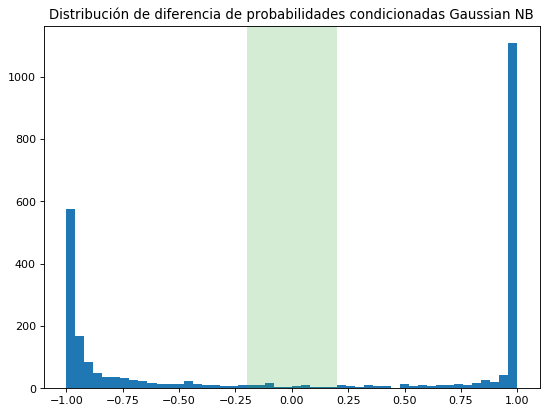

In [14]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Distribución de diferencia de probabilidades condicionadas Gaussian NB')
plt.hist(diferencia,bins=50)
plt.axvspan(-0.2,0.2, facecolor='#2ca02c', alpha=0.2)
plt.show()

## 4. Comparación de algorítmos
Comparar Naive Bayes y árboles de decisión. Para hacerlo usar 5-fold crossvalidation para la exploración de la mejor solución en cada caso. En árboles de
decisión determinar qué tamaño de árbol conviene y si conviene utilizar Gini o
Information Gain (todo esto con el conjunto de desarrollo y utilizando grid search).
Utilizar ROC AUC como métrica.

In [15]:
# se instancia el modelo NB 
model = GaussianNB()
model.fit(X,y)

# en train
scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('scoring ROC train:   ',round(100*scores.mean(),2),'%')
predict_test_nb=model.predict(test_X)

scoring ROC train:    81.86 %


In [16]:
# estimamos con los parámetros optimos
print('scoring ROC test :   ',round(roc_auc_score(test_y, predict_test_nb)*100,2),'%')
print()
print('Reporte de metricas:')
print (classification_report(test_y, predict_test_nb))
print()
print('accuracy en test :  ',round(accuracy_score(test_y, predict_test_nb), 2)*100,'%')

scoring ROC test :    72.86 %

Reporte de metricas:
              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1614
           1       0.60      0.75      0.67       966

   micro avg       0.72      0.72      0.72      2580
   macro avg       0.72      0.73      0.72      2580
weighted avg       0.74      0.72      0.73      2580


accuracy en test :   72.0 %


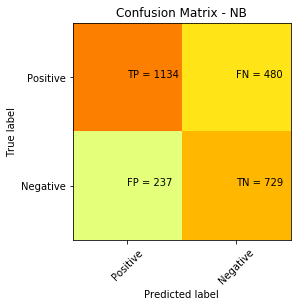

In [17]:
cm=confusion_matrix(test_y, predict_test_nb)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Positive','Negative']
plt.title('Confusion Matrix - NB')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TP','FN'], ['FP', 'TN']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

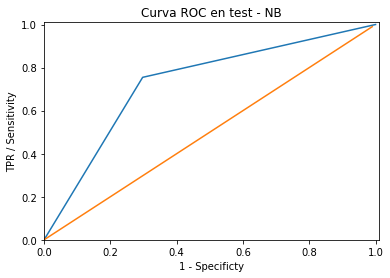

In [18]:
# graficamos curva ROC
fpr,tpr,_ = roc_curve(test_y, predict_test_nb)
nb_df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('Curva ROC en test - NB')
plt.plot(nb_df['fpr'],nb_df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 

Optimizamos el algoritmo de Árbol de decisión

In [19]:
# se optimiza el modelo de AD - se definen los parámetros a testear
profundidad = list(range(1, 41))
criterio = ["gini","entropy"]
split=['best','random']

In [20]:
#instanciamos el modelo
tree = DecisionTreeClassifier(max_depth = 3, criterion = 'gini',splitter='best')
        
param_grid = dict(max_depth=profundidad, criterion=criterio,splitter=split)
grid = GridSearchCV(tree, param_grid, cv=5, scoring='roc_auc')
grid.fit(X, y)

print (grid.best_estimator_)
print()
print('mejor estimación:   ',round(grid.best_score_*100,2),'%')

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

mejor estimación:    83.11 %


In [21]:
# estimamos con los parámetros optimos
predict_test_ad=grid.predict(test_X)
print('scoring ROC test :   ',round(roc_auc_score(test_y, predict_test_ad)*100,2),'%')
print()
print('Reporte de metricas:')
print (classification_report(test_y, predict_test_ad))
print()
print('accuracy en test :  ',round(accuracy_score(test_y, predict_test_ad), 2)*100,'%')

scoring ROC test :    74.75 %

Reporte de metricas:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84      1614
           1       0.76      0.61      0.68       966

   micro avg       0.78      0.78      0.78      2580
   macro avg       0.78      0.75      0.76      2580
weighted avg       0.78      0.78      0.78      2580


accuracy en test :   78.0 %


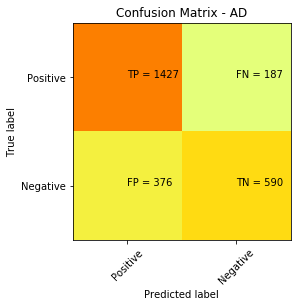

In [22]:
cm=confusion_matrix(test_y, predict_test_ad)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Positive','Negative']
plt.title('Confusion Matrix - AD')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TP','FN'], ['FP', 'TN']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

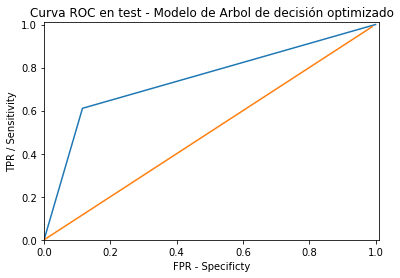

In [23]:
# graficamos curva ROC
fpr1,tpr1,_ = roc_curve(test_y, predict_test_ad)
df_ad = pd.DataFrame(dict(fpr=fpr1, tpr=tpr1))

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('FPR - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('Curva ROC en test - Modelo de Arbol de decisión optimizado')
plt.plot(df_ad['fpr'],df_ad['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.show() 

Comparamos Curvas ROC

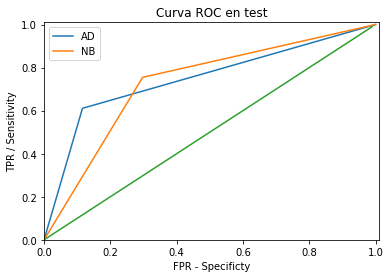

In [24]:
# graficandolos conjuntamente

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('FPR - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('Curva ROC en test')
plt.plot(df_ad['fpr'],df_ad['tpr'])
plt.plot(nb_df['fpr'],nb_df['tpr'])
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.gca().legend(('AD','NB'))
plt.show() 
